# Session 5: Supervised Learning: 

# Classification with k-NN and Decision Trees a gentle introduction


We will cover two popular and simple classification algorithms:
- **k-Nearest Neighbors (k-NN)**
- **Decision Trees**

At the end, you will have hands-on practice with exercises.

*Machine learning* is less a single field and more a mindset, a way of thinking about data, patterns, and decision-making. It draws on ideas from **statistics**,**optimization** **physics**, **computer science**, which makes it both rich and challenging. When you first dive in, it can feel like difficult, but that diversity also means there’s something in it that will resonate uniquely with you. To get started, focus on the core tools that let you experiment confidently: **linear algebra** to understand structure, **probability** to reason under uncertainty, and **multivariable calculus** to grasp dynamics. Pair these with hands-on coding skills, especially in Python, so you can explore, visualize, and manipulate real-world data from day one.

## Learning Goals
By the end of this lesson, you should be able to:
- Understand the intuition behind k-NN and Decision Trees
- Writing code from scratch
- Train and test these models using scikit-learn
- Compare their performance
- Solve small classification problems with Python

##  What is Supervised Learning?

Supervised learning is a type of machine learning where the algorithm is trained on **labeled data**.  
Each data point (or **instance**) comes with a known output (class or value).  
The algorithm learns patterns in the input data (features) to predict the output for new, unseen data.


# Part 1:  KNN Classificaction

## Simple Example: Weather Data

Let’s imagine we are the machine and want to learn from a small dataset.  

We have weather data for three days.  
Each day, we record two **features**:  

- **Temperature** (°C)  
- **Wind Speed** (km/h)  

Each day also belongs to a **class**: `Rain` or `No Rain`.  

Lower temperature + higher wind → Rain

Moderate/high temperature + low wind → No Rain

This is our dataset:


In [75]:
import pandas as pd

# Simple dataset
data = {
    "Day": [1, 2, 3, 4, 5, 6, 7],
    "Temperature (°C)": [18, 21, 25, 16, 28, 22, 19],
    "Wind Speed (km/h)": [12, 5, 8, 15, 3, 6, 10],
    "Class": ["Rain", "No Rain", "No Rain", "Rain", "No Rain", "No Rain", "Rain"]
}

df = pd.DataFrame(data)
df


,Day,Temperature (°C),Wind Speed (km/h),Class
0,1,18,12,Rain
1,2,21,5,No Rain
2,3,25,8,No Rain
3,4,16,15,Rain
4,5,28,3,No Rain
5,6,22,6,No Rain
6,7,19,10,Rain


We call each row a **data point** (or instance).  
The combination of **temperature** and **wind speed** forms an **instance vector**.


##  Visualizing the Data

Let’s plot our data points in 2D space.  
Each point represents a day, with temperature on the x-axis and wind speed on the y-axis.


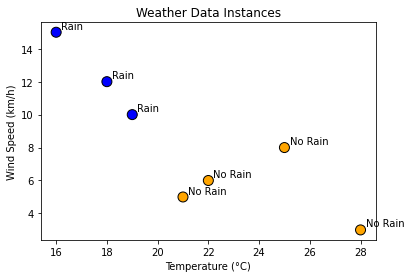

In [39]:
import matplotlib.pyplot as plt

temperature = df["Temperature (°C)"]
wind_speed = df["Wind Speed (km/h)"]
labels = df["Class"]

# Color points by class
colors = ["blue" if label == "Rain" else "orange" for label in labels]

plt.scatter(temperature, wind_speed, c=colors, s=100, edgecolor="k")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind Speed (km/h)")
plt.title("Weather Data Instances")

# Add labels to points
for i, label in enumerate(labels):
    plt.text(temperature.iloc[i] + 0.2, wind_speed.iloc[i] + 0.2, label)

plt.show()


##  How KNN Works

**K-Nearest Neighbors (KNN)** is a simple algorithm:

1. Given a new instance, calculate the **distance** between it and all instances in the training dataset.  
   - Common metrics: *Euclidean distance*, *Manhattan distance*.  
2. Identify the **K nearest neighbors** (the closest data points).  
3. For **classification**, the predicted class is the **majority vote** among the neighbors.    

👉 KNN is called a **lazy learner** because it does not build a model during training—it just stores the dataset and makes predictions when needed.


##  Important Considerations in KNN

- **Choosing K**:  
  - Small K (e.g., 1) → sensitive to noise.  
  - Large K → smoother, but may ignore local patterns.  

- **Distance Metrics**:  
  - Euclidean, Manhattan, Minkowski, cosine similarity.  

- **Feature Scaling**:  
  - KNN is sensitive to feature scales. Normalize features so that one feature doesn’t dominate.  

- **Efficiency**:  
  - KNN stores all data → slow for very large datasets.


##  Key Takeaways

- KNN is a **non-parametric, instance-based** learning algorithm.  
- It makes predictions by **comparing distances** between data points.  
- Despite its simplicity, it’s effective for small datasets and is widely used as a baseline method.  
- Understanding KNN builds intuition for more advanced machine learning methods.  


#  Writing KNN from Scratch

While libraries like `scikit-learn` make KNN easy to use, it’s important to understand how the algorithm works internally.  
We’ll build KNN step by step.

We will implement:

1. A **distance function** (Euclidean distance).  
2. A function to find the **k nearest neighbors**.  
3. A **majority voting mechanism** for classification.  
4. A **prediction function**.  


### Distance Example: Euclidean Distance

For two points \\(x = (x_1, x_2)\\) and \\(y = (y_1, y_2)\\):

\\[
d(x, y) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2}
\\]


### Step 1: Distance Function

The core of KNN is the distance calculation.  
We’ll use **Euclidean distance**:

\\[
d(x, y) = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}
\\]


In [8]:
x1 = np.array([20, 10])
print('x1:',x1.tolist())


x1: [20, 10]


In [9]:
x2 = np.array([23, 7])
print('x2:',x2.tolist())


x2: [23, 7]


In [10]:
import numpy as np

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# Test example
print(euclidean_distance(np.array([20, 10]), np.array([23, 7])))


4.242640687119285


### Step 2: Finding Nearest Neighbors

For a new data point:
- Compute distance to **all training instances**.  
- Sort by distance.  
- Pick the top **k neighbors**.


In [28]:

# Features (Temperature, Wind Speed)
X_train = df[["Temperature (°C)", "Wind Speed (km/h)"]].values
X_train

array([[20,  5],
       [24,  6],
       [22,  8],
       [30,  3],
       [18, 10]])

In [29]:
y_train = df["Class"].values
y_train

array(['Rain', 'No Rain', 'No Rain', 'No Rain', 'Rain'], dtype=object)

In [43]:
def get_neighbors(X_train, y_train, new_point, k=3):
    distances = [] # Creates an empty Python list to hold pairs (distance, corresponding_label).
    for i, x in enumerate(X_train): # (*)
        dist = euclidean_distance(new_point, x)
        distances.append((dist, y_train[i]))
    
    # Sort by distance
    distances.sort(key=lambda x: x[0])
    
    # Select k nearest neighbors (list comprehension)
    neighbors = [label for (_, label) in distances[:k]]
    return neighbors

# Test with our dataset
X_train = df[["Temperature (°C)", "Wind Speed (km/h)"]].values
y_train = df["Class"].values

print(get_neighbors(X_train, y_train, np.array([23, 7]), k=3))


['No Rain', 'No Rain', 'No Rain']


In [21]:
# (x) enumerate(X_train) loops through each training sample x and also gives its index i. 
#You need i to fetch the matching label from y_train.

### Step 3: Majority Vote

For classification, we choose the **most frequent class** among neighbors.


In [33]:
from collections import Counter

def majority_vote(neighbors):
    counter = Counter(neighbors)
    return counter.most_common(1)[0][0]

# Example
print(majority_vote(["Rain", "No Rain", "Rain"]))


Rain



- Counter(neighbors) → counts how many times each label appears

- .most_common(1) → finds the label with the highest count

- [0][0] → extracts just the label

- return → gives you the predicted class

# Homework : Convert it all to Class concept
Explain why it is sueful to convert to class than using only functions?

### Step 4: Full KNN Classifier

Now we combine everything into a class `KNNClassifier`.


In [40]:
class KNNClassifier:
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict_one(self, x):
        neighbors = get_neighbors(self.X_train, self.y_train, x, self.k)
        return majority_vote(neighbors)

    def predict(self, X):
        return [self.predict_one(x) for x in X]

# Test the scratch KNN
knn_scratch = KNNClassifier(k=1)
knn_scratch.fit(X_train, y_train)

print("Prediction for new point [23, 7]:", knn_scratch.predict([np.array([23, 7])]))


Prediction for new point [23, 7]: ['No Rain']


## Comparing with scikit-learn

Let’s compare our scratch implementation with scikit-learn’s KNN.
Source code for scikit-learn


In [76]:
from sklearn.neighbors import KNeighborsClassifier

# Features and labels
X = df[["Temperature (°C)", "Wind Speed (km/h)"]]
y = df["Class"]

# Build a KNN model with k=1
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

# Predict for a new day
new_day = [[23, 7]]
prediction = knn.predict(new_day)
print("Prediction for Temperature=23, Wind Speed=7:", prediction[0])


Prediction for Temperature=23, Wind Speed=7: No Rain


/Users/zainabnazari/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [42]:
# Scratch prediction
print("Scratch KNN:", knn_scratch.predict([np.array([23, 7])])[0])

# sklearn prediction
print("scikit-learn KNN:", knn.predict([[23, 7]])[0])


Scratch KNN: No Rain
scikit-learn KNN: No Rain


/Users/zainabnazari/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


# Comparing with scikit-learn

the source:  https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/neighbors/_classification.py

| Feature                        | Current Code                                   | scikit-learn                                                                                                     |
|--------------------------------|--------------------------------------------|-----------------------------------------------------------------------------------------------------------------|
| **Distance metrics**            | Fixed (likely Euclidean in `get_neighbors`) | Supports multiple metrics: Euclidean, Manhattan, Minkowski, cosine, etc. (`metric` parameter)                  |
| **Weighting neighbors**         | All neighbors are equal                     | Supports weighted votes: closer neighbors can have more influence (`weights='distance'`)                        |
| **Efficient search**            | Computes distance to all points every time | Uses optimized algorithms: KD-tree, Ball-tree, or brute-force with efficient vectorization (`algorithm` parameter) |
| **Batch predictions**           | Loops manually over all points             | Vectorized, highly optimized for speed, supports large datasets                                                 |
| **Handling ties**               | Not explicitly handled                      | Implements tie-breaking rules or weights to handle ties                                                         |
| **Multi-class & multi-output**  | Works if you code it manually               | Handles multi-class and multi-output classification automatically                                               |
| **Built-in evaluation**         | None                                       | Provides `.score()` method to compute accuracy, cross-validation compatible                                     |
| **Integration with pipelines**  | Manual                                     | Works seamlessly with `Pipeline`, `GridSearchCV`, `StandardScaler`, etc.                                        |
| **Parameter tuning**            | Manual                                     | Can use `GridSearchCV` or `RandomizedSearchCV` to find best `k`, metric, or weights                              |


##  Summary

- We built KNN **step by step**: distance → neighbors → majority vote → prediction.  
- Our scratch implementation matches scikit-learn’s KNN.  
- Writing algorithms from scratch deepens intuition and helps understand what libraries do behind the scenes.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

# Example with Iris dataset 

In [12]:
# Example with Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # first two features for visualization
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7777777777777778


Let's visualize the decision boundaries for k-NN.

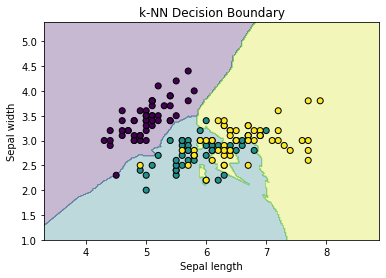

In [4]:
# Decision boundary visualization
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('k-NN Decision Boundary')
plt.show()

# Part 2: Decision Trees

# 🌳 Decision Trees

Decision Trees are a type of **supervised learning algorithm**.  
They try to achieve the same goal as algorithms like *k-Nearest Neighbors (kNN)*:  
to classify instances based on their attributes.

---

## 🔹 How Decision Trees Work

- A decision tree is built as a hierarchy of **questions about attributes**.  
- At each **node**:
  - We split the data into subsets depending on the value of a chosen attribute.
  - The attribute is chosen to **minimize uncertainty (entropy)** and maximize information gain.
- This process repeats:
  - Each subset is split again based on another attribute.
  - The result is a tree structure, where following the questions eventually leads to a classification.
  
  
  # Can High-Speed Wind and High Temperature Cause Rain?

## 1. High Temperature
- Hot air can hold more **moisture (water vapor)**.
- Hot air rises (**convection**) and **cools** as it goes up.
- Cooling causes water vapor to **condense into clouds** → potential **rain**.

## 2. High-Speed Wind
- Wind **moves air masses**:
  - Brings **moist air** from oceans or lakes.
  - Forces air to **rise over mountains** (orographic lifting).
  - Causes **air convergence**, helping cloud formation.
- Wind itself does **not directly create rain**.

## 3. Combined Effect
- **Hot + humid air + rising winds** → clouds → rain.
- Common in **tropical regions** → thunderstorms or monsoon rain.



---

## 🔹 Example: Predicting Rain ☔

Suppose our decision tree has learned the following rule:

> It **rains** if:  
> - Temperature < 5°C  
> **OR**  
> - (Temperature > 30°C **and** Wind speed > 50 km/h)

---

### 🌡️ Step-by-step classification

1. **First question:** Is the temperature > 30°C?  
   - If **yes** → Check wind speed.  
   - If **no** → Check if temperature < 5°C.

2. **Case A: Temperature = 35°C**  
   - Since 35°C > 30°C, the tree asks: *Is wind speed > 50 km/h?*  
     - If **yes** → Predict **Rain**.  
     - If **no** → Predict **No Rain**.

3. **Case B: Temperature = 2°C**  
   - Since 2°C ≤ 30°C, the tree asks: *Is temperature < 5°C?*  
     - If **yes** → Predict **Rain**.  
     - If **no** → Predict **No Rain**.

---

## 🔹 Summary

- A **Decision Tree** is a sequence of yes/no questions.  
- Each question splits the dataset into smaller, more homogeneous groups.  
- Eventually, these questions lead to a **final decision (class label)**.  
- Trees are powerful because they are:
  - **Intuitive** (easy to interpret)  
  - **Flexible** (handle both categorical & numerical data)  
  - But they can also **overfit** without pruning or depth limits.


## Advantages:
- Easy to interpret
- Can handle numerical and categorical data

## Disadvantages:
- Can overfit if not pruned

## Step 1: Build our dataset

We will create synthetic data (temperature, wind) and label it according to the rule:
- Rain = 1 if temp < 5 OR (temp > 30 AND wind > 50)
- Otherwise Rain = 0


# Decision Tree Analysis for Rain Dataset

We have a toy dataset with:
- `temperature` (°C)
- `wind` (km/h)
- `rain` (0 = No, 1 = Yes)

We will use a simple decision tree from scratch to classify whether it will rain.


In [70]:
# Step 0: Import libraries
import numpy as np
import pandas as pd

# Generate toy dataset
np.random.seed(42)
temperature = np.random.randint(-5, 40, 200)   # -5 to 40°C
wind = np.random.randint(0, 100, 200)          # 0 to 100 km/h

# Apply rule: rain = 1 if temp<5 or (temp>30 and wind>50)
rain = ((temperature <= 5) | ((temperature > 30) & (wind > 50))).astype(int)

# Put into DataFrame
df = pd.DataFrame({"temperature": temperature, "wind": wind, "rain": rain})
df.head(10)


,temperature,wind,rain
0,33,58,1
1,23,1,0
2,9,1,0
3,37,91,1
4,2,53,1
5,15,86,0
6,33,95,1
7,13,96,0
8,17,0,0
9,5,18,1


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

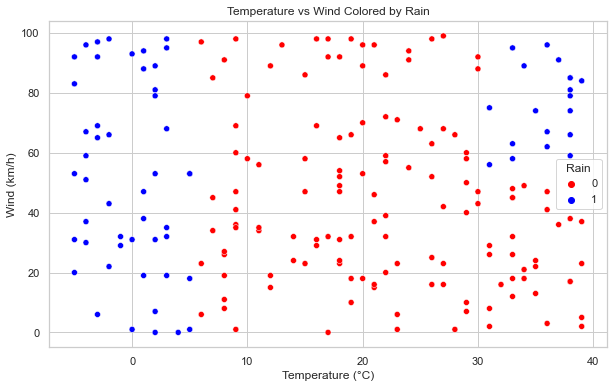

In [73]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='temperature', y='wind', hue='rain', palette={1:'blue', 0:'red'})
plt.title("Temperature vs Wind Colored by Rain")
plt.xlabel("Temperature (°C)")
plt.ylabel("Wind (km/h)")
plt.legend(title='Rain')
plt.show()

# Entropy and Information Gain

## 1. Entropy

Entropy measures the **uncertainty or disorder** in a dataset.  

**Formula:**

\\[
\text{Entropy}(S) = - \sum_{i=1}^{n} p_i \cdot \log_2(p_i)
\\]

Where:  
- \\(S\\) = the dataset  
- \\(n\\) = number of classes (categories)  
- \\(p_i\\) = fraction of samples in class \\(i\\) (probability of class \\(i\\))  

**Explanation:**  
- Entropy = 0 → all samples belong to **one class** (no uncertainty)  
- Entropy = maximum → samples are **evenly split among classes** (high uncertainty)  
- \\(\log_2(p_i)\\) measures the **surprise** of seeing a sample from class \\(i\\)  
- Multiplying by \\(p_i\\) weights the surprise by probability  
- The minus sign makes the entropy **positive**  

---

## 2. Information Gain

Information Gain measures how much **uncertainty is reduced** when we split the dataset based on a feature.  

**Formula:**

\\[
IG(S, A) = Entropy(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} \cdot Entropy(S_v)
\\]

Where:  
- \\(S\\) = current dataset (or node)  
- \\(A\\) = feature we are considering to split on  
- \\(v\\) = each possible value of feature \\(A\\)  
- \\(S_v\\) = subset of \\(S\\) where feature \\(A = v\\)  
- \\(|S_v|\\) = number of samples in subset \\(S_v\\)  
- \\(|S|\\) = total number of samples in \\(S\\)  
- \\(Entropy(S_v)\\) = entropy of subset \\(S_v\\)  

**Explanation:**  
1. Compute entropy of the dataset **before the split**  
2. Compute the **weighted entropy** after splitting by the feature  
3. Subtract the weighted entropy from the original entropy → this is **Information Gain**  

- High IG → splitting on this feature **reduces uncertainty a lot** (good feature)  
- Low IG → splitting on this feature **does not help much**  

---

**Simple analogy:**  
- Entropy = “How messy the data is”  
- Information Gain = “How much cleaner we get after asking a question about a feature”


## Step 1: Prepare dataset for our simple tree

We convert the DataFrame to numpy arrays:


In [47]:
X = df[['temperature', 'wind']].values
y = df['rain'].values
features = ['temperature', 'wind']


## Step 2: Define entropy function
Entropy measures the uncertainty in the labels.


In [48]:
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))

print("Entropy of rain:", entropy(y))


Entropy of rain: 0.8988610370442902


## Step 3: Information Gain for numeric features
Since `temperature` and `wind` are numeric, we need a **threshold split**.  
We will test **all unique values** as thresholds and pick the one with **highest information gain**.


In [49]:
def best_split_numeric(X_column, y):
    thresholds = np.unique(X_column)
    best_gain = 0
    best_threshold = None
    total_entropy = entropy(y)
    
    for t in thresholds:
        left_mask = X_column <= t
        right_mask = X_column > t
        if sum(left_mask) == 0 or sum(right_mask) == 0:
            continue
        weighted_entropy = (sum(left_mask)/len(y))*entropy(y[left_mask]) + \
                           (sum(right_mask)/len(y))*entropy(y[right_mask])
        gain = total_entropy - weighted_entropy
        if gain > best_gain:
            best_gain = gain
            best_threshold = t
    return best_gain, best_threshold


## Step 4: Find the best feature and threshold
We loop over both features and pick the best split.


In [50]:
def best_feature_numeric(X, y, feature_names):
    best_gain = 0
    best_feature_index = None
    best_threshold = None
    
    for i in range(X.shape[1]):
        gain, threshold = best_split_numeric(X[:, i], y)
        if gain > best_gain:
            best_gain = gain
            best_feature_index = i
            best_threshold = threshold
            
    return best_feature_index, best_threshold

best_idx, best_thresh = best_feature_numeric(X, y, features)
print("Best feature:", features[best_idx], "with threshold:", best_thresh)



Best feature: temperature with threshold: 4


## Step 5: Build the decision tree recursively
We handle numeric splits: left = <= threshold, right = > threshold


In [52]:
def build_tree_numeric(X, y, feature_names):
    if len(np.unique(y)) == 1:
        return y[0]
    if X.shape[1] == 0:
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]
    
    best_idx, best_thresh = best_feature_numeric(X, y, feature_names)
    if best_idx is None:
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]
    
    tree = {feature_names[best_idx]: {'threshold': best_thresh}}
    
    left_mask = X[:, best_idx] <= best_thresh
    right_mask = X[:, best_idx] > best_thresh
    
    left_subtree = build_tree_numeric(X[left_mask, :], y[left_mask], feature_names)
    right_subtree = build_tree_numeric(X[right_mask, :], y[right_mask], feature_names)
    
    tree[feature_names[best_idx]]['left'] = left_subtree
    tree[feature_names[best_idx]]['right'] = right_subtree
    
    return tree

tree = build_tree_numeric(X, y, features)
tree


{'temperature': {'threshold': 4,
  'left': 1,
  'right': {'temperature': {'threshold': 30,
    'left': 0,
    'right': {'wind': {'threshold': 49, 'left': 0, 'right': 1}}}}}}

## Step 6: Predict function for numeric tree


In [53]:
def predict_numeric(tree, sample):
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree))
    thresh = tree[feature]['threshold']
    if sample[features.index(feature)] <= thresh:
        return predict_numeric(tree[feature]['left'], sample)
    else:
        return predict_numeric(tree[feature]['right'], sample)

# Test prediction
sample = [32, 60]  # temperature=32°C, wind=60 km/h
print("Prediction for sample", sample, ":", predict_numeric(tree, sample))


Prediction for sample [32, 60] : 1


# Summary
- Built a **simple decision tree for numeric features** from scratch.
- Steps:
  1. Compute **entropy**.
  2. Compute **information gain** for each feature and threshold.
  3. Choose the **best feature and threshold**.
  4. Recursively split data to build the tree.
  5. Predict by traversing the tree.
- Works for numeric datasets like temperature and wind.


# Scikit-learn

In [55]:
# 📦 Import libraries
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt
from sklearn import tree


In [61]:
# Step 0: Import scikit-learn
from sklearn.tree import DecisionTreeClassifier

# Step 1: Prepare data
X = df[['temperature', 'wind']].values
y = df['rain'].values

# Step 2: Create and fit the decision tree
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X, y)

# Step 3: Predict for a new sample
sample = [[32, 60]]  # temperature=32°C, wind=60 km/h
prediction = clf.predict(sample)
print("Prediction for sample", sample[0], ":", prediction[0])


Prediction for sample [32, 60] : 1


Train a Decision Tree Classifier
We’ll train with **entropy** criterion, which uses Information Gain.


##  Visualize the Decision Tree


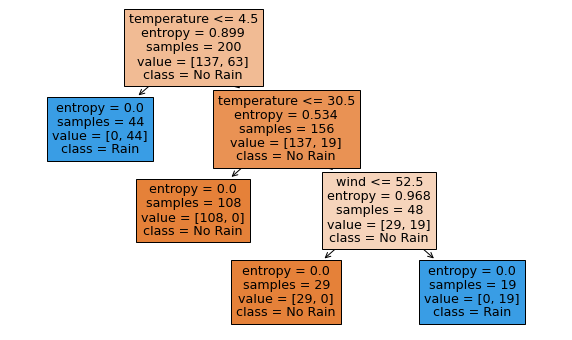

In [62]:
plt.figure(figsize=(10,6))
plot_tree(clf, feature_names=["temperature", "wind"], class_names=["No Rain", "Rain"], filled=True)
plt.show()


##  Show the Rules Learned


In [63]:
print(export_text(clf, feature_names=["temperature", "wind"]))


|--- temperature <= 4.50
|   |--- class: 1
|--- temperature >  4.50
|   |--- temperature <= 30.50
|   |   |--- class: 0
|   |--- temperature >  30.50
|   |   |--- wind <= 52.50
|   |   |   |--- class: 0
|   |   |--- wind >  52.50
|   |   |   |--- class: 1



## Classify Example Days

Let’s test:
- Day A: 35°C, 60 km/h → should be Rain  
- Day B: 35°C, 30 km/h → should be No Rain  
- Day C: 2°C, 10 km/h → should be Rain  
- Day D: 15°C, 20 km/h → should be No Rain


In [59]:
examples = pd.DataFrame({
    "temperature": [35, 35, 2, 15],
    "wind": [60, 30, 10, 20]
}, index=["Day A", "Day B", "Day C", "Day D"])

preds = clf.predict(examples)
probs = clf.predict_proba(examples)

results = examples.copy()
results["predicted_rain"] = preds
results["probability_rain"] = probs[:,1]
results


,temperature,wind,predicted_rain,probability_rain
Day A,35,60,1,1.0
Day B,35,30,0,0.0
Day C,2,10,1,1.0
Day D,15,20,0,0.0


## Decision Paths
We can trace how the tree makes decisions for each day.


In [67]:
node_indicator = clf.decision_path(examples)
feature = clf.tree_.feature
threshold = clf.tree_.threshold

for i, day in enumerate(examples.index):
    print(f"\n🌦 {day}: temperature={examples.iloc[i,0]}, wind={examples.iloc[i,1]}")
    node_index = node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]]
    for node_id in node_index:
        if feature[node_id] != -2:
            if examples.iloc[i, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"
            print(f"   Node {node_id}: (feature {feature[node_id]}) "
                  f"{examples.columns[feature[node_id]]} = {examples.iloc[i, feature[node_id]]} "
                  f"{threshold_sign} {threshold[node_id]:.2f}")



🌦 Day A: temperature=35, wind=60
   Node 0: (feature 0) temperature = 35 > 4.50
   Node 2: (feature 0) temperature = 35 > 30.50
   Node 4: (feature 1) wind = 60 > 52.50

🌦 Day B: temperature=35, wind=30
   Node 0: (feature 0) temperature = 35 > 4.50
   Node 2: (feature 0) temperature = 35 > 30.50
   Node 4: (feature 1) wind = 30 <= 52.50

🌦 Day C: temperature=2, wind=10
   Node 0: (feature 0) temperature = 2 <= 4.50

🌦 Day D: temperature=15, wind=20
   Node 0: (feature 0) temperature = 15 > 4.50
   Node 2: (feature 0) temperature = 15 <= 30.50


/Users/zainabnazari/opt/miniconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## Exercises (30 minutes)

1. **Play with k in k-NN:** Try different values of `k` (1, 3, 7, 15). How does accuracy change?
2. **Use all 4 features:** Train both k-NN and Decision Tree on the full Iris dataset (not just 2 features). Compare results.
3. **New dataset:** Generate a synthetic dataset using `make_classification` with 2 classes and 2 features. Train both classifiers and compare performance.
4. **Decision Tree depth:** Try different values of `max_depth` (None, 2, 5, 10). What happens?
5. **Challenge:** Use `classification_report` to compare precision, recall, and F1-score between k-NN and Decision Tree.

Discuss results with a partner or write down your conclusions.